In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
from rubin_sim.maf import radar
import os

from matplotlib.legend_handler import HandlerErrorbar

In [2]:
def norm_df(
    df,
    runs,
    cols,
    norm_run="baseline",
    invert_cols=None,
    reverse_cols=None,
    run_label="run_name",
    mag_cols=[],
):
    """
    Normalize values in a dataframe to a given run
    Parameters
    ----------
    df : pandas.DataFrame
        The input data frame
    runs : list of str
        A list of run numes
    cols : list of str
        A list of columns in df to use
    norm_run : str
        The row to use to normalize things to
    invert_cols : list of str
        A list of column names that should be inverted (e.g., columns that
        are uncertainties and are better with a smaller value)
    reverse_cols : list of str
        Columns to reverse (e.g., magnitudes)
    run_label : str (run_name)
        The column that has run names
    mag_cols : list of str
        Columns that are in magnitudes
    """
    indices = [np.max(np.where(df.index == name)[0]) for name in runs]
    out_df = df[cols].iloc[indices].copy()
    if reverse_cols is not None:
        for colname in reverse_cols:
            out_df[colname] = -out_df[colname]
    if invert_cols is not None:
        for colname in invert_cols:
            out_df[colname] = 1.0 / out_df[colname]
    if norm_run is not None:
        indx = np.max(np.where(out_df.index == norm_run)[0])
        for col in out_df.columns:
            # maybe just check that it's not a
            if col != "run_name":
                if (col in mag_cols) | (mag_cols == "all"):
                    out_df[col] = 1.0 + (out_df[col] - out_df[col].iloc[indx])
                else:
                    out_df[col] = (
                        1.0
                        + (out_df[col] - out_df[col].iloc[indx])
                        / out_df[col].iloc[indx]
                    )
    return out_df

In [3]:

data_loaded = pd.read_hdf('summary.h5')
data_loaded.shape

(50, 46777)

In [4]:
#data_loaded['Total detected -6.4 LVDwarfs gi UserPointsSlicer']

In [18]:
[col for col in data_loaded.columns if 'FootprintFraction' in col]

['FootprintFraction N year 1 g and night < 365 HealpixSlicer',
 'FootprintFraction N year 1 i and night < 365 HealpixSlicer',
 'FootprintFraction N year 1 r and night < 365 HealpixSlicer',
 'FootprintFraction N year 1 u and night < 365 HealpixSlicer',
 'FootprintFraction N year 1 y and night < 365 HealpixSlicer',
 'FootprintFraction N year 1 z and night < 365 HealpixSlicer']

In [40]:
# Pull out the metrics we are interested in and define simple names

name_dict = {            'FootprintFraction N year 1 u and night < 365 HealpixSlicer': 'FF u',
            'FootprintFraction N year 1 g and night < 365 HealpixSlicer': 'FF g',
            'FootprintFraction N year 1 r and night < 365 HealpixSlicer': 'FF r',

            'FootprintFraction N year 1 i and night < 365 HealpixSlicer': 'FF i',

    'best18k parallax HealpixSlicer': 'parallax best 18k',
            'best18k properMotion HealpixSlicer': 'proper motion best 18k',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 20_30 days UserPointsSlicer': '20-30d microlensing\ndetection',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 60_90 days UserPointsSlicer': '60-90d microlensing\ndetection',
            'fONv MedianNvis fO HealpixSlicer': 'fO N vis',
            'Total detected SNNSNMetric_reducen_sn DDF excluded HealpixSlicer': 'SNe, N',
             'Median SNNSNMetric_reducezlim DDF excluded HealpixSlicer': 'SNe, zlim',
            '3x2ptFoM Exgalm5WithCuts i band non-DD year 10 HealpixSlicer': '3x2 i-band',
            'Median WeakLensingNvisits gri band non-DD HealpixSlicer': 'WL Nvis \ni-band',
            'Total detected KNePopMetric_all_ztfrest_simple all models UserPointsSlicer': 'KNe ZTF simple',
             'Total detected KNePopMetric_single_ztfrest_simple single model UserPointsSlicer': 'KNe single model',
            'Total detected XRBPopMetric_early_detect UserPointsSlicer': 'XRB\nearly detect',
            'VolumeSum Brown Dwarf, L7 HealpixSlicer': 'Brown Dwarf Vol',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO bright',
            'CumulativeCompleteness H <= 22.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO faint',
            'CumulativeCompleteness H <= 6.000000 DiscoveryNChances TNO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'TNO',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances MBA 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'MBA',
            'CumulativeCompleteness H <= 18.000000 DiscoveryNChances Trojan 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'Trojan',

            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances Vatira 1 quad in 1 night detection loss MoObjSlicer': 'Vatira',
}

# drop in the units for the columns
units = {'parallax best 18k': 'mas',
         'proper motion best 18k': 'mas/yr',
         '20-30d microlensing\ndetection': 'fraction', 
         '60-90d microlensing\ndetection': 'fraction', 
         'fO N vis' : '', 
         'SNe, N': '', 
         'SNe, zlim': '', 
         '3x2 i-band': 'score', 
         'WL Nvis \ni-band': '', 
         'KNe ZTF simple': 'N', 
         'KNe single model': 'N',
         'XRB\nearly detect': 'N', 
         'Brown Dwarf Vol': 'pc^3', 
         'NEO bright': 'fraction', 
         'NEO faint': 'fraction', 
         'TNO': 'fraction', 
         'MBA':'fraction',
         'Trojan': 'fraction',
         'Vatira': 'fraction',
        }

# If columns are uncertainties, we want to plot them backwards
invert_cols = ['parallax best 18k', 'proper motion best 18k']
# If columns are mags or fractions, we want to plot differences, not fractional differences.
mag_cols = ['20-30d microlensing\ndetection', '60-90d microlensing\ndetection','SNe, zlim',
            'NEO bright', 'NEO faint', 'TNO', 'Vatira', 'MBA', 'Trojan', 'FF u', 'FF g']

data = pd.DataFrame()
for key in name_dict:
    data[name_dict[key]] = data_loaded[key]
    

mag_dict = {'Median CoaddM5 g HealpixSlicer': 'g',
 'Median CoaddM5 i HealpixSlicer': 'i',
 'Median CoaddM5 r HealpixSlicer': 'r',
 'Median CoaddM5 u HealpixSlicer': 'u',
 'Median CoaddM5 y HealpixSlicer': 'y',
 'Median CoaddM5 z HealpixSlicer': 'z'}

mag_data = pd.DataFrame()
for key in mag_dict:
    mag_data[mag_dict[key]] = data_loaded[key]
    
    
    
ddf_dict = {'Sum SNNSNMetric DD:COSMOS_reducen_sn DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN COSMOS',
           'Sum SNNSNMetric DD:ECDFS_reducen_sn DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ECDFS',
           'Sum SNNSNMetric DD:EDFS_reducen_sn DD:EDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN EDFS',
           'Sum SNNSNMetric DD:ELAISS1_reducen_sn DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ELAISS1',
           'Sum SNNSNMetric DD:XMM_LSS_reducen_sn DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN XMM_LSS',
            
           'Median SNNSNMetric DD:COSMOS_reducezlim DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer': 'zlim COSMOS',
            'Median SNNSNMetric DD:ECDFS_reducezlim DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim ECDFS',
            'Median SNNSNMetric DD:EDFS_reducezlim DD:EDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim EDFS',
            'Median SNNSNMetric DD:ELAISS1_reducezlim DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer': 'zlim ELAISS1',
            'Median SNNSNMetric DD:XMM_LSS_reducezlim DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer': 'zlim XMM_LSS',
            
           }

ddf_data = pd.DataFrame()
for key in ddf_dict:
    ddf_data[ddf_dict[key]] = data_loaded[key]
 

In [41]:
data

,FF u,FF g,FF r,FF i,parallax best 18k,proper motion best 18k,20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,"SNe, N",...,KNe ZTF simple,KNe single model,XRB\nearly detect,Brown Dwarf Vol,NEO bright,NEO faint,TNO,MBA,Trojan,Vatira
starter_v3.1_10yrs,0.771066,0.902656,0.989747,0.998888,0.802899,0.187499,0.3346,0.4664,795.0,118003.590290,...,3599.0,5363.0,2049.0,171619.716167,0.9288,0.640267,0.721860,0.929189,0.603105,0.0471
ug_y1_utw_100_gtw_100_v3.1_10yrs,0.970424,0.983200,0.998147,0.996665,0.785548,0.187996,0.3342,0.4703,797.0,123851.615237,...,3661.0,5551.0,1951.0,174532.874036,0.9236,0.632080,0.716875,0.924303,0.594415,0.0494
ug_y1_utw_100_gtw_125_v3.1_10yrs,0.971540,0.987770,0.997035,0.992094,0.783230,0.187821,0.3239,0.4574,798.0,124048.445356,...,3583.0,5566.0,2002.0,174555.883971,0.9242,0.635389,0.718816,0.923726,0.610290,0.0463
ug_y1_utw_100_gtw_12_v3.1_10yrs,0.972656,0.897838,0.987153,0.999135,0.782413,0.188092,0.3294,0.4618,797.0,124217.450623,...,3577.0,5447.0,1999.0,175451.518535,0.9266,0.638347,0.719691,0.925940,0.601932,0.0447
ug_y1_utw_100_gtw_150_v3.1_10yrs,0.971401,0.983817,0.997653,0.993576,0.781664,0.188161,0.3280,0.4615,798.0,123869.082772,...,3574.0,5579.0,1958.0,174456.673720,0.9246,0.633671,0.718683,0.924438,0.608825,0.0462
ug_y1_utw_100_gtw_24_v3.1_10yrs,0.967913,0.966893,0.995059,0.997653,0.785035,0.188159,0.3283,0.4630,798.0,124709.809306,...,3578.0,5414.0,1977.0,174439.850342,0.9246,0.634131,0.719685,0.925185,0.599144,0.0512
ug_y1_utw_100_gtw_50_v3.1_10yrs,0.975028,0.986782,0.994565,0.994565,0.783657,0.188235,0.3381,0.4750,797.0,123871.047019,...,3607.0,5547.0,2043.0,173873.333856,0.9272,0.635115,0.717898,0.924734,0.584068,0.0470
ug_y1_utw_100_gtw_75_v3.1_10yrs,0.972517,0.986411,0.998271,0.993700,0.780946,0.189004,0.3250,0.4593,798.0,124223.544343,...,3538.0,5532.0,1982.0,174171.295717,0.9290,0.634769,0.719182,0.921858,0.590989,0.0485
ug_y1_utw_125_gtw_100_v3.1_10yrs,0.981166,0.982458,0.999506,0.993576,0.783304,0.188844,0.3241,0.4559,797.0,123612.032112,...,3626.0,5648.0,1975.0,174434.674092,0.9286,0.635779,0.717689,0.924426,0.588181,0.0477
ug_y1_utw_125_gtw_125_v3.1_10yrs,0.971959,0.981717,0.999382,0.994317,0.786471,0.188304,0.3395,0.4741,797.0,123622.243631,...,3671.0,5566.0,2010.0,174326.081332,0.9262,0.634685,0.717656,0.919807,0.593237,0.0470


In [42]:
#data['KNe single model'] # data['KNe ZTF simple']

In [43]:
# A bit of a mystery why baseline_v3.0_10yrs is so much better. 
# The KNe ZTF simple and KNe single model don't seem to
# be particularly well correlated. Seems like it has to be an MJD_start bug somewhere, but I can't find it.
#data['KNe ZTF simple']

In [30]:
mag_data

,g,i,r,u,y,z
starter_v3.1_10yrs,26.702741,26.275374,26.811500,25.679105,24.771007,25.561028
ug_y1_utw_100_gtw_100_v3.1_10yrs,26.688299,26.281258,26.816815,25.612646,24.774375,25.573667
ug_y1_utw_100_gtw_125_v3.1_10yrs,26.687928,26.285187,26.816390,25.616541,24.764342,25.575783
ug_y1_utw_100_gtw_12_v3.1_10yrs,26.697480,26.286236,26.814060,25.611817,24.775886,25.575389
ug_y1_utw_100_gtw_150_v3.1_10yrs,26.673797,26.282083,26.814057,25.621316,24.763531,25.578749
ug_y1_utw_100_gtw_24_v3.1_10yrs,26.690307,26.281214,26.817891,25.630603,24.773851,25.576542
ug_y1_utw_100_gtw_50_v3.1_10yrs,26.687621,26.283573,26.815801,25.624905,24.767934,25.568609
ug_y1_utw_100_gtw_75_v3.1_10yrs,26.694730,26.281929,26.817325,25.626572,24.770836,25.568456
ug_y1_utw_125_gtw_100_v3.1_10yrs,26.687658,26.286942,26.816456,25.604972,24.776815,25.574131
ug_y1_utw_125_gtw_125_v3.1_10yrs,26.685738,26.282428,26.817736,25.621850,24.776067,25.569290


In [31]:
ddf_data
#ddf_data = ddf_data.reindex(new_ind)

,N SN COSMOS,N SN ECDFS,N SN EDFS,N SN ELAISS1,N SN XMM_LSS,zlim COSMOS,zlim ECDFS,zlim EDFS,zlim ELAISS1,zlim XMM_LSS
starter_v3.1_10yrs,569.390177,324.557076,696.511503,299.499915,319.197748,0.573324,0.585288,0.527892,0.574021,0.564239
ug_y1_utw_100_gtw_100_v3.1_10yrs,571.231794,323.789100,696.015708,300.131183,312.422315,0.569469,0.585029,0.528157,0.572365,0.561189
ug_y1_utw_100_gtw_125_v3.1_10yrs,571.680927,327.243728,695.180690,297.797515,316.002304,0.570374,0.584991,0.527830,0.572766,0.560548
ug_y1_utw_100_gtw_12_v3.1_10yrs,569.384380,322.065062,699.296744,300.433324,317.030436,0.570678,0.584064,0.526906,0.572466,0.563062
ug_y1_utw_100_gtw_150_v3.1_10yrs,576.696440,323.209918,697.697220,298.747827,317.085995,0.571649,0.585333,0.525508,0.569637,0.565033
ug_y1_utw_100_gtw_24_v3.1_10yrs,572.957633,326.628178,695.805526,299.251290,316.569606,0.568831,0.585810,0.525629,0.573521,0.566467
ug_y1_utw_100_gtw_50_v3.1_10yrs,572.629726,322.681855,692.490439,293.424544,307.621661,0.570677,0.582656,0.526224,0.573752,0.564675
ug_y1_utw_100_gtw_75_v3.1_10yrs,570.106773,321.143873,688.669364,299.863595,315.653110,0.570275,0.584991,0.526585,0.572729,0.564501
ug_y1_utw_125_gtw_100_v3.1_10yrs,570.572425,324.659854,688.674507,296.956523,309.628294,0.568923,0.583667,0.527840,0.573658,0.562926
ug_y1_utw_125_gtw_125_v3.1_10yrs,570.559382,326.476331,692.271872,300.693025,311.636165,0.570210,0.583644,0.525599,0.574073,0.559559


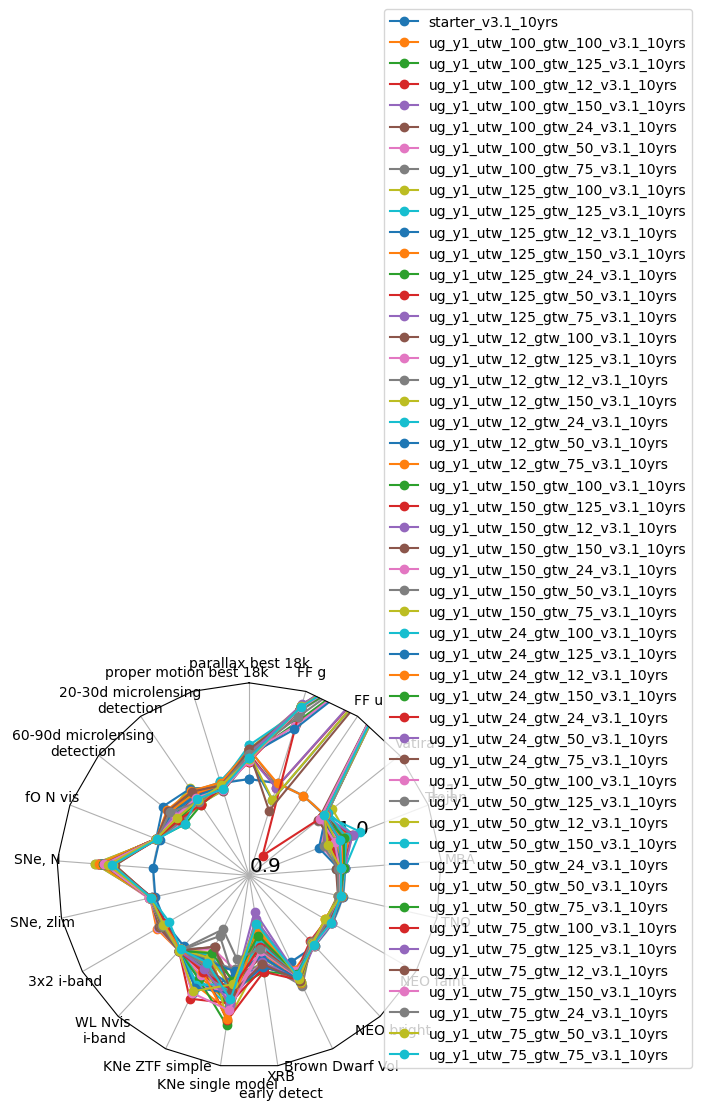

In [32]:
runs = [run for run in data.index ]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='starter_v3.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

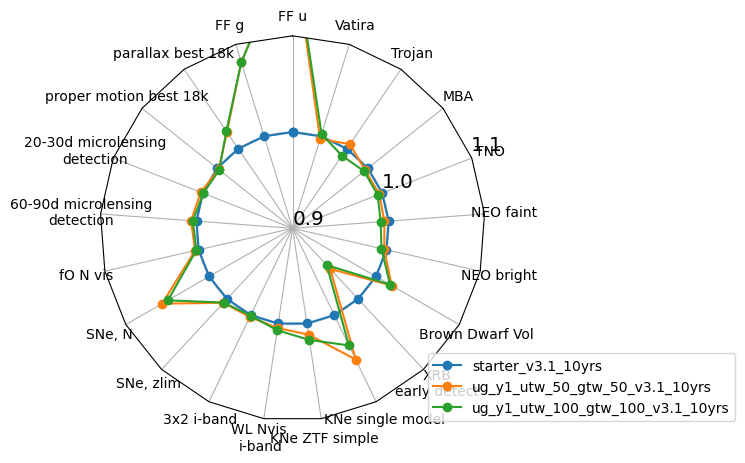

In [39]:
runs = ['starter_v3.1_10yrs', 'ug_y1_utw_50_gtw_50_v3.1_10yrs', 'ug_y1_utw_100_gtw_100_v3.1_10yrs']
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='starter_v3.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

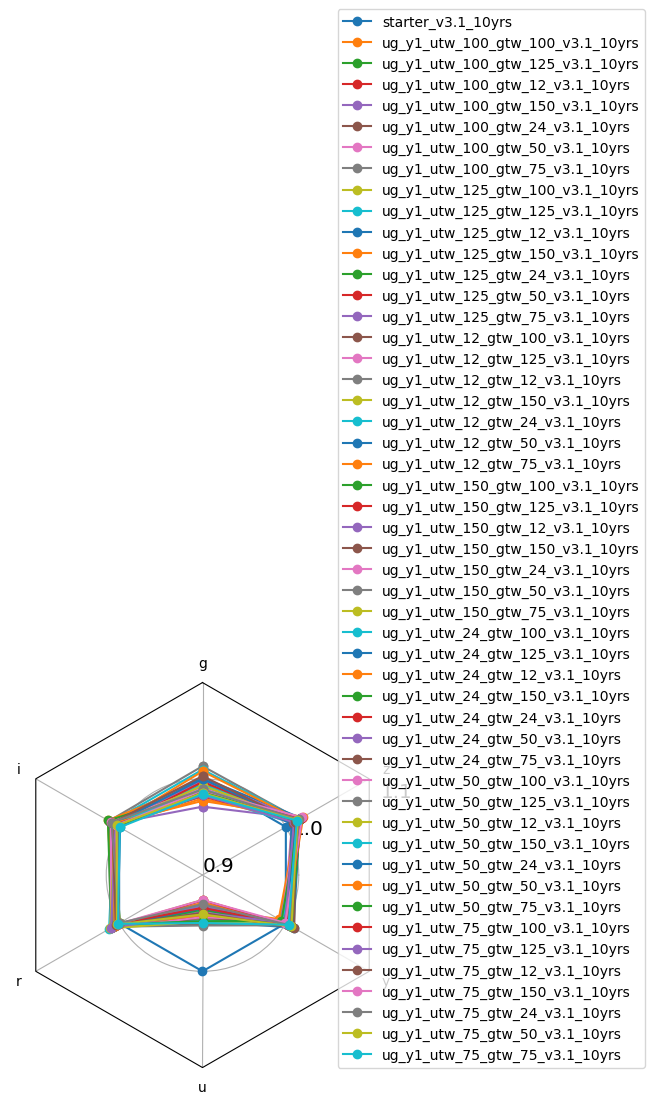

In [15]:
ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                mag_cols='all', norm_run='starter_v3.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))